In [1]:
import copy
import os
import sys
import time

sys.path.append('..')

from src.experiments.register import *
from src.experiments.argument_handling import *
from src.envs.creation import make_env
from src.envs.simulation import *
from src.utils.constants import *
from src.agents import *
from src.agents.base import *
from src.agents.exploration import *

import gym
from gym_gridworld.envs.gridworld_env import GridworldEnv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm

os.environ['WANDB_SILENT'] = 'true'
wandb.init()

%matplotlib inline

In [2]:
DEVICE = 'cuda'

In [3]:
# env = make_env('Gridworld')

# print(env.unwrapped.current_grid_map)

# obs = env.reset()
# plt.imshow(obs.squeeze())

# plt.imshow(generate_random_state(env).squeeze())

In [4]:
# Creates a state where the agent is in a random position
def generate_random_state(env):
    valid_state = False
    while not valid_state:
        state = [np.random.randint(0, env.unwrapped.grid_map_shape[0]), \
                 np.random.randint(0, env.unwrapped.grid_map_shape[1])]
        # If location is empty or goal state
        if env.unwrapped.current_grid_map[state[0], state[1]] in (0, 3):
            valid_state = True
    obs, _, _, _ = copy.deepcopy(env).jump_to_state(state)
    return env.observation(obs)

In [5]:
class NoRewardWrapper(gym.RewardWrapper):
  def __init__(self, env):
    super().__init__(env)

  def reward(self, _):
    return 0

class NoTerminationWrapper(gym.Wrapper):
  def __init__(self, env):
    super().__init__(env)

  def step(self, action):
    obs, reward, done, info = self.env.step(action)
    return obs, reward, False, info

class RandomTerminationWrapper(gym.Wrapper):
  def __init__(self, env, termination_chance=0.01):
    super().__init__(env)
    self.termination_chance = termination_chance

  def step(self, action):
    obs, reward, done, info = self.env.step(action)
    if np.random.random() < self.termination_chance:
      done = True
    return obs, reward, done, info

explore_env = \
  RandomTerminationWrapper(
    NoTerminationWrapper(
      NoRewardWrapper(
        make_env('Gridworld'))), 0.001)

In [6]:
# EzExplore with an experience buffer
class ExplorerAgent(EzExplorerAgent, ExperienceBufferMixin):
  def init(*args, **kwargs):
    super().__init__(*args, **kwargs)

  def process_step_data(self, transition_data):
    if transition_data is not None:
      self.append_buffer(transition_data)

In [8]:
explore_steps = 50000
explore_print_freq = 5000

explore_agent = ExplorerAgent(explore_env)
train_exploration_model(explore_agent, explore_env, explore_steps, print_freq=explore_print_freq)

Step: 5000 | Episodes: 3 | Ep rewards: 0.0000
Step: 10000 | Episodes: 3 | Ep rewards: 0.0000
Step: 15000 | Episodes: 5 | Ep rewards: 0.0000
Step: 20000 | Episodes: 3 | Ep rewards: 0.0000
Step: 25000 | Episodes: 1 | Ep rewards: 0.0000
Step: 30000 | Episodes: 7 | Ep rewards: 0.0000
Step: 35000 | Episodes: 9 | Ep rewards: 0.0000
Step: 40000 | Episodes: 5 | Ep rewards: 0.0000
Step: 45000 | Episodes: 4 | Ep rewards: 0.0000


## Goal-conditioned policy learning steps

1. Create a new environment that includes the goal as part of the state
2. Create Rainbow agent with the new env specification
3. Use the explorer experience buffer to create random relabeled trajectories
    - New trajectories should have new discounted rewards for the chosen goal state
    - The chosen goal state should be concatted with the observations
4. Add relabeled trajectories to the Rainbow agent's replay buffer
5. Make an offline training loop for Rainbow


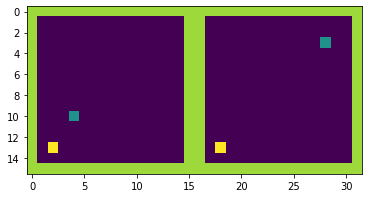

In [9]:
### Create a new environment that includes the goal as part of the state ###

class GoalWrapper(gym.Wrapper):
  def __init__(self, env, goal_state=None, goal_chooser=None):
    super().__init__(env)
    self.goal_state = goal_state
    self.goal_chooser = goal_chooser
    prev_shape = self.observation_space.shape
    self.observation_space = gym.spaces.Box(
        low = np.concatenate(2 * [self.observation_space.low], axis=0),
        high = np.concatenate(2 * [self.observation_space.high], axis=0),
        shape = (2 * prev_shape[0],) + prev_shape[1:],
        dtype = self.observation_space.dtype)

  def reset(self, **kwargs):
    obs = self.env.reset(**kwargs)
    if self.goal_chooser is not None:
      self.goal_state = self.goal_chooser(self.env)
    return self.observation(obs)

  def step(self, action):
    obs, _, _, info = self.env.step(action)
    return self.observation(obs), self.reward(obs), self.terminal(obs), info

  def observation(self, obs):
    return torch.cat([obs, self.goal_state], dim=0)

  def reward(self, obs):
    return 1 if (obs == self.goal_state).all() else 0

  def terminal(self, obs):
    return (obs == self.goal_state).all()

  def set_goal_state(self, state):
    self.goal_state = state

goal_env = GoalWrapper(make_env('Gridworld'), goal_chooser=generate_random_state)

obs = goal_env.reset()
plt.imshow(torch.cat([obs[0], obs[1]], dim=1).squeeze())

In [ ]:
class OfflineDQN(DDDQNAgent):
  def __init__(self, *args, bc_weight=0.2, **kwargs):
      super().__init__(*args, **kwargs)

  def calculate_losses(self):
    batch_data = self.prepare_batch_data()
    obs, acts, n_step_rewards, final_obs, terminals, final_gammas = batch_data
    final_q_values = self.model(final_obs)
    max_next_acts = torch.argmax(final_q_values, dim=1, keepdim=True).detach()
    
    final_q_values = self.target_model(final_obs)
    max_final_q_values = final_q_values.gather(index=max_next_acts, dim=1)
    max_final_q_values = max_final_q_values.view(-1).detach()
    terminal_mods = 1 - terminals
    target_qs = n_step_rewards + terminal_mods * final_gammas * max_final_q_values

    pred_qs = self.model(obs)
    pred_qs = pred_qs.gather(index=acts.view(-1, 1), dim=1).view(-1)
    
    losses = (target_qs.detach() - pred_qs) ** 2
    return losses

  def train(self):
    self.model.train()

    losses = self.calculate_losses()

    obs, behavior_acts, _, _, _, _ = self.prepare_batch_data()
    policy_acts = self.model(obs).argmax(dim=1)

    

    loss = losses.mean()
    wandb.log({'dqn_loss': loss.item()})
    self.losses.append(loss.item())
    
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    return loss.item()

In [10]:
dqn_model = DDDQNNetwork(list(goal_env.observation_space.shape), goal_env.action_space.n)
task_agent = DDDQNAgent(goal_env, dqn_model)

In [79]:
### Use the explorer experience buffer to create random relabeled trajectories ###

samples_per_trajectory = 4
min_trajectory_length = 5

# Loop through experience buffer
task_agent.start_task(0)
bar = tqdm(total=len(explore_agent.exp_buffer))
buffer_idx = 0
while buffer_idx < len(explore_agent.exp_buffer[:10000]):
    # Collect transitions from one trajctory
    trajectory = []
    for i in range(buffer_idx, len(explore_agent.exp_buffer)):
        transition = explore_agent.exp_buffer[i]
        if transition[4]: # If done
            break
    trajectory = explore_agent.exp_buffer[buffer_idx:i+1]
    bar.update(len(trajectory))
    buffer_idx = i + 1

    # If trajectory is too short, skip to next trajectory
    if len(trajectory) < min_trajectory_length:
        continue

    # Resample & relabel new trajectories
    for _ in range(samples_per_trajectory):
        if np.random.rand() < 0.5:
            goal_idx = np.random.randint(1, len(trajectory))
            start_idx = np.random.randint(0, goal_idx)
        else:
            start_idx = np.random.randint(0, len(trajectory)-1)
            goal_idx = np.random.randint(start_idx+1, len(trajectory))
        # end_idx = goal_idx # Could try changing this, or make start index always 0
        #                    # If this is changed, make sure to also change terminals below

        goal_state = copy.deepcopy(trajectory[goal_idx][3])
        new_trajectory = copy.copy(trajectory[start_idx:goal_idx+1])
        new_goal_idx = goal_idx - start_idx
        for i in range(0, len(new_trajectory)):
            transition = new_trajectory[i]
            new_transition = [0, 0, 0, 0, 0]
            # Append goal state to obs
            # print((transition[0] == goal_state).all())
            new_transition[0] = torch.cat([transition[0], goal_state], dim=0)
            # Set action
            new_transition[1] = transition[1]
            # Change rewards
            if (transition[3] == goal_state).all():
                new_transition[2] = 1 # Goal reward
                new_transition[4] = True # Done
            else:
                new_transition[2] = 0 # Non-goal reward
                new_transition[4] = False # Not done
            # Append goal state to next_obs
            new_transition[3] = torch.cat([transition[3], goal_state], dim=0)
            # Change terminals

            # task_agent.append_buffer(copy.deepcopy(new_transition))
            task_agent.process_step_data(copy.deepcopy(new_transition))

            if new_transition[4]:
                break
        task_agent.end_episode()

bar.close()
# print('# steps:', task_agent.mem.transitions.index)
print('# steps:', task_agent.buffer_size())

 50%|█████     | 10037/20000 [00:00<00:00, 24058.08it/s]

# steps: 4890


0.0 False 0.8863848717161292


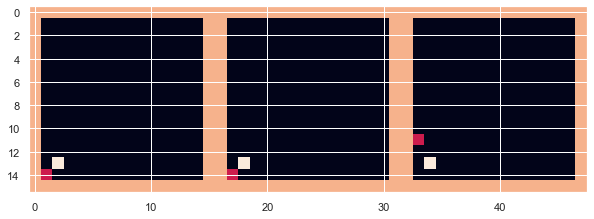

In [80]:
obs, act, n_step_reward, final_obs, done, final_gamma = task_agent.exp_buffer[-18]
# Increase plot x size
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(torch.cat([obs[0].cpu(), final_obs[0].cpu(), obs[1].cpu()], dim=1).squeeze())
print(n_step_reward, done, final_gamma)

tensor(False) 0.0 0.0


e:\projects\rl_representation_learning\notebooks\..\src\agents\base.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.stack([torch.tensor(se, dtype=torch.float32) for se in e], \


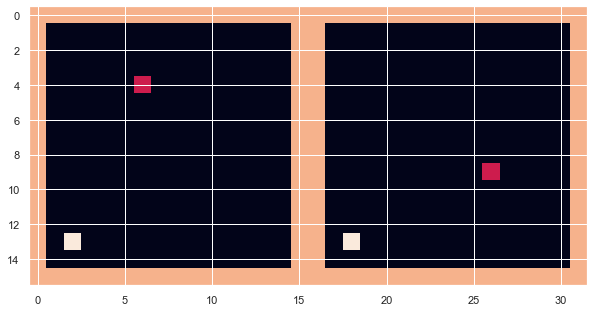

In [81]:
i = 0
transition = task_agent.sample_buffer(1)
n_step_reward = -11.361513137817383
# while n_step_reward == -11.361513137817383:
obs, act, n_step_reward, final_obs, done, final_gamma = transition
plt.imshow(torch.cat([obs[0, 0].cpu(), obs[0, 1].cpu()], dim=1).squeeze())
print((obs[0, 0] == obs[0, 1]).all(), done.item(), n_step_reward.item())

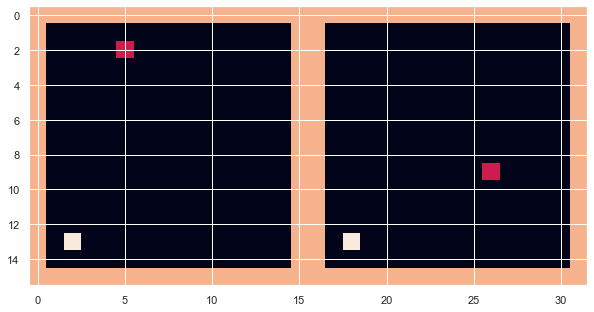

In [82]:
plt.imshow(torch.cat([final_obs[0, 0].cpu(), final_obs[0, 1].cpu()], dim=1).squeeze())

In [85]:
n_train_steps = 20000
print_freq = 200

task_agent.model.train()
losses = []
for batch_idx in range(n_train_steps):
    # Train with n-step distributional double-Q learning
    loss = task_agent.train()
    losses.append(loss)

    # # Update target network
    # if batch_idx % task_agent.args.target_update == 0:
    #     task_agent.dqn.update_target_net()

    # Update target network
    if batch_idx % task_agent.target_update_freq == 0:
        task_agent._update_target_network()

    if batch_idx % print_freq == 0:
        print('Step: {} | Loss: {:.3f}'.format(batch_idx, np.mean(losses[-print_freq:])))

e:\projects\rl_representation_learning\notebooks\..\src\agents\base.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.stack([torch.tensor(se, dtype=torch.float32) for se in e], \
e:\projects\rl_representation_learning\notebooks\..\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32) \


Step: 0 | Loss: 0.016
Step: 200 | Loss: 0.013
Step: 400 | Loss: 0.013
Step: 600 | Loss: 0.013
Step: 800 | Loss: 0.013
Step: 1000 | Loss: 0.013
Step: 1200 | Loss: 0.012
Step: 1400 | Loss: 0.013
Step: 1600 | Loss: 0.012
Step: 1800 | Loss: 0.011
Step: 2000 | Loss: 0.012
Step: 2200 | Loss: 0.010
Step: 2400 | Loss: 0.011
Step: 2600 | Loss: 0.011
Step: 2800 | Loss: 0.010
Step: 3000 | Loss: 0.010
Step: 3200 | Loss: 0.009
Step: 3400 | Loss: 0.009
Step: 3600 | Loss: 0.009
Step: 3800 | Loss: 0.008
Step: 4000 | Loss: 0.008
Step: 4200 | Loss: 0.007
Step: 4400 | Loss: 0.007
Step: 4600 | Loss: 0.007
Step: 4800 | Loss: 0.008
Step: 5000 | Loss: 0.008
Step: 5200 | Loss: 0.008
Step: 5400 | Loss: 0.008
Step: 5600 | Loss: 0.007
Step: 5800 | Loss: 0.008
Step: 6000 | Loss: 0.007
Step: 6200 | Loss: 0.008
Step: 6400 | Loss: 0.008
Step: 6600 | Loss: 0.008
Step: 6800 | Loss: 0.008
Step: 7000 | Loss: 0.007
Step: 7200 | Loss: 0.008
Step: 7400 | Loss: 0.007
Step: 7600 | Loss: 0.007
Step: 7800 | Loss: 0.007
Step: 8

KeyboardInterrupt: 

In [89]:
### Test the agent ###

def eval_agent(agent, env, n_episodes=10, max_steps=200, render=False):
    all_rewards = []
    for _ in tqdm(range(n_episodes)):
        ep_reward = 0
        obs = env.reset()
        for _ in range(max_steps):
            act = agent.sample_act(obs)
            obs, reward, done, _ = env.step(act)
            ep_reward += reward
            if render:
                env.render()
                time.sleep(0.05)
            if done:
                break

        all_rewards.append(ep_reward)

    return all_rewards

task_agent.model.eval()
rewards = eval_agent(task_agent, goal_env, n_episodes=10)
print(rewards)

100%|██████████| 10/10 [00:01<00:00,  5.75it/s]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


tensor(True, device='cuda:0') 1.0 -18.209304809570312


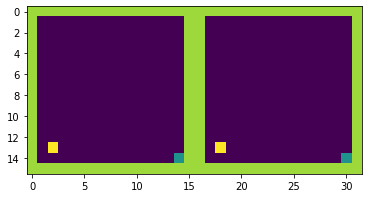

In [253]:
i = 0
transition = task_agent.mem.sample(1)
_, obs, act, ret, next_obs, done, _ = transition
plt.imshow(torch.cat([obs[0, 0].cpu(), obs[0, 1].cpu()], dim=1).squeeze())
print((obs[0, 0] == obs[0, 1]).all(), done.item(), ret.item())

In [201]:
obs = explore_agent.exp_buffer[0][0]
print(obs.shape)
plt.imshow(torch.cat([obs[0].cpu(), obs[1].cpu()], dim=1).squeeze())

torch.Size([1, 16, 16])


IndexError: index 1 is out of bounds for dimension 0 with size 1

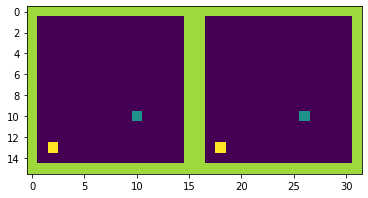

In [176]:
plt.imshow(torch.cat([obs[0, 0].cpu(), obs[0, 1].cpu()], dim=1).squeeze())